In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import math
import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.layers import LSTM, GRU
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.models import load_model
from datetime import date
from datetime import timedelta

training_start_time = time.time()

today = date.today()
data_end_date = today.strftime("%Y-%m-%d")
start_date = date.today() - timedelta(days=1095)
data_start_date = start_date.strftime("%Y-%m-%d")
df_data = yf.download('XRP-USD', start=data_start_date, end=data_end_date)

[*********************100%***********************]  1 of 1 completed


In [2]:
def move_close_to_first_column(df_data):
    df_data.drop(columns=['Adj Close'], inplace=True)
    close_price_column = df_data.pop('Close')
    df_data.insert(0, 'Close', close_price_column)
    return df_data

In [3]:
def prepare_ti_dataset(df_data):
    df_data.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
    CustomStrategy = ta.Strategy(
        name="Technical indicators",
        description="SMA 5, 10, 20, 30, 50, WMA 10, 20, 30, RSI, EMA, MACD",
        ta=[
            {"kind": "sma", "length": 5},
            {"kind": "sma", "length": 10},
            {"kind": "sma", "length": 20},
            {"kind": "sma", "length": 30},
            {"kind": "sma", "length": 50},
            {"kind": "wma", "length": 10},
            {"kind": "wma", "length": 20},
            {"kind": "wma", "length": 30},
            {"kind": "rsi"},
            {"kind": "ema"},
            {"kind": "macd", "fast": 8, "slow": 21},
        ]
    )

    df_data.ta.strategy(CustomStrategy)
    df_data = df_data.dropna()
    return df_data

In [4]:
def prepare_combined_dataset(df_data):
    df_data.drop(columns=['Open', 'Volume'], inplace=True)
    CustomStrategy = ta.Strategy(
        name="Basic features and technical indicators",
        description="SMA 5, WMA 10, EMA",
        ta=[
            {"kind": "sma", "length": 5},
            {"kind": "wma", "length": 10},
            {"kind": "ema"},
        ]
    )

    df_data.ta.strategy(CustomStrategy)
    df_data = df_data.dropna()
    return df_data

In [5]:
df_data = move_close_to_first_column(df_data)
# df_data = prepare_ti_dataset(df_data)
# df_data = prepare_combined_dataset(df_data)

In [6]:
prediction_days = int(len(df_data)*0.2)

df_train = df_data[:len(df_data) - prediction_days]
df_test = df_data[len(df_data)-prediction_days:]

actual_test_df = df_test

columns_count = len(df_data.columns)
df_train = df_train.values.reshape(-1, columns_count)
df_test = df_test.values.reshape(-1, columns_count)

# Normalize data
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

result_scaler = MinMaxScaler(feature_range=(0, 1))
result_scaler.fit_transform(df_test[:, 0:1])

array([[7.91307255e-04],
       [0.00000000e+00],
       [2.28791011e-03],
       [1.06459288e-02],
       [1.46360565e-02],
       [6.27379669e-02],
       [6.49187847e-02],
       [8.71824801e-02],
       [1.07414361e-01],
       [8.52451223e-02],
       [8.88028772e-02],
       [9.11851812e-02],
       [7.38498599e-02],
       [1.03934298e-01],
       [1.44987882e-01],
       [1.24395002e-01],
       [1.19009046e-01],
       [1.69333747e-01],
       [1.33156055e-01],
       [1.54116252e-01],
       [1.38185142e-01],
       [1.43827194e-01],
       [1.34052328e-01],
       [1.45869454e-01],
       [1.05626069e-01],
       [1.30389608e-01],
       [1.46138123e-01],
       [1.37437935e-01],
       [1.42597196e-01],
       [1.40708129e-01],
       [1.14748122e-01],
       [1.01917184e-01],
       [1.25173673e-01],
       [1.12890583e-01],
       [8.01761269e-02],
       [8.05518883e-02],
       [8.34127299e-02],
       [6.50971885e-02],
       [5.75262859e-02],
       [8.00523326e-02],


In [7]:
# Dataset Generator for GRU
def dataset_generator(dataset, look_back=5):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 1:]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

In [8]:
look_back_period = 15
trainX, trainY = dataset_generator(scaled_train, look_back_period)
testX, testY = dataset_generator(scaled_test, look_back_period)

In [9]:
def get_gru_model(timesteps_count, features_count):
    regressor=Sequential()
    regressor.add(GRU(32,return_sequences=True,input_shape=(timesteps_count, features_count)))
    regressor.add(Dropout(0.2))
    regressor.add(GRU(32,return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(GRU(32))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(1))

    regressor.compile(loss='mean_squared_error',optimizer='adam')
    regressor.summary()
    return regressor

In [10]:
timesteps_count = trainX.shape[1]
features_count = trainX.shape[2]
regressor = get_gru_model(timesteps_count, features_count)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 32)            3552      
_________________________________________________________________
dropout (Dropout)            (None, 15, 32)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 32)            6240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [11]:
checkpoint_path = 'rnn-multivariate.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/600
27/27 [==============================] - 6s 55ms/step - loss: 0.0099 - val_loss: 0.0321

Epoch 00001: val_loss improved from inf to 0.03209, saving model to rnn-multivariate.hdf5
Epoch 2/600
27/27 [==============================] - 1s 34ms/step - loss: 0.0193 - val_loss: 0.0090

Epoch 00002: val_loss improved from 0.03209 to 0.00901, saving model to rnn-multivariate.hdf5
Epoch 3/600
27/27 [==============================] - 1s 27ms/step - loss: 0.0099 - val_loss: 0.0099

Epoch 00003: val_loss did not improve from 0.00901
Epoch 4/600
27/27 [==============================] - 1s 30ms/step - loss: 0.0073 - val_loss: 0.0078

Epoch 00004: val_loss improved from 0.00901 to 0.00780, saving model to rnn-multivariate.hdf5
Epoch 5/600
27/27 [==============================] - 1s 33ms/step - loss: 0.0056 - val_loss: 0.0094

Epoch 00005: val_loss did not improve from 0.00780
Epoch 6/600
27/27 [==============================] - 1s 28ms/step - loss: 0.0057 - val_loss: 0.0115

Epoch 00006: v

27/27 [==============================] - 1s 27ms/step - loss: 0.0031 - val_loss: 0.0062

Epoch 00051: val_loss did not improve from 0.00456
Epoch 52/600
27/27 [==============================] - 1s 27ms/step - loss: 0.0030 - val_loss: 0.0058

Epoch 00052: val_loss did not improve from 0.00456
Epoch 53/600
27/27 [==============================] - 1s 30ms/step - loss: 0.0029 - val_loss: 0.0046

Epoch 00053: val_loss did not improve from 0.00456
Epoch 54/600
27/27 [==============================] - 1s 29ms/step - loss: 0.0032 - val_loss: 0.0047

Epoch 00054: val_loss did not improve from 0.00456
Epoch 55/600
27/27 [==============================] - 1s 28ms/step - loss: 0.0028 - val_loss: 0.0050

Epoch 00055: val_loss did not improve from 0.00456
Epoch 56/600
27/27 [==============================] - 1s 33ms/step - loss: 0.0026 - val_loss: 0.0051

Epoch 00056: val_loss did not improve from 0.00456
Epoch 57/600
27/27 [==============================] - 1s 26ms/step - loss: 0.0031 - val_loss: 0

In [12]:
training_time = time.time() - training_start_time
predicting_start_time = time.time()

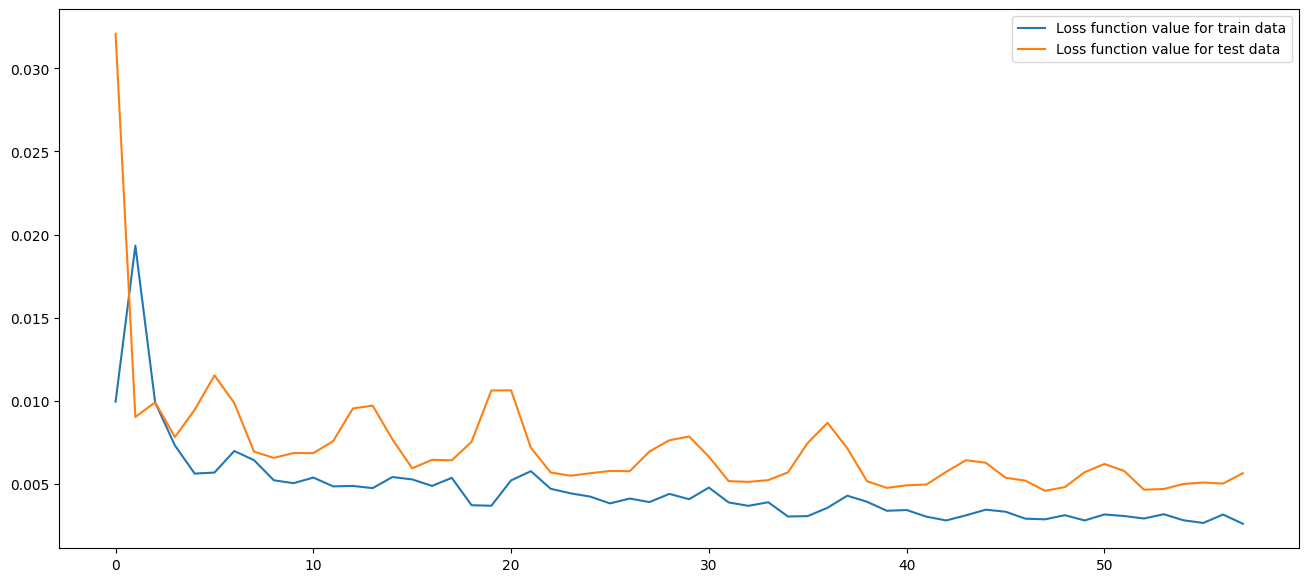

In [13]:
# Plot line graph to show Loss Numbers relative to the epoch
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='Loss function value for train data')

plt.plot(history.history['val_loss'], label='Loss function value for test data')
plt.legend()
plt.show()

In [14]:
model_from_saved_checkpoint = load_model(checkpoint_path)

# Prediction for the existing data
predicted_price = model_from_saved_checkpoint.predict(testX)

predicted_price = result_scaler.inverse_transform(predicted_price.reshape(-1, 1))
test_actual = result_scaler.inverse_transform(testY.reshape(-1, 1))

df_data_len = len(df_data)
date_range = df_data[df_data_len-len(predicted_price):].index

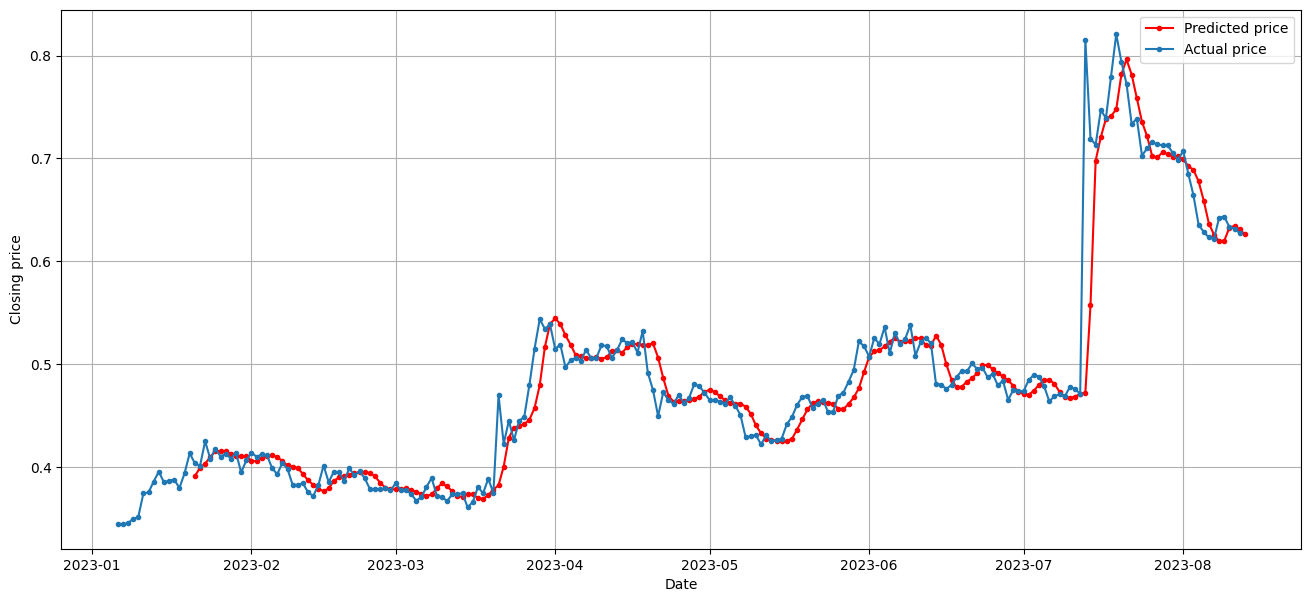

In [15]:
# Predicting next day price
x_input = scaled_test[-look_back_period:, 1:]
x_input = x_input.reshape(1, look_back_period, features_count)

prediction_for_next_day = model_from_saved_checkpoint.predict(x_input)
next_day_price = result_scaler.inverse_transform(prediction_for_next_day.reshape(-1, 1))
next_day_price = next_day_price.reshape(-1)[0]

date_range = actual_test_df.index.tolist()
date_range.append(date.today())

predicted_prices = predicted_price.reshape(-1).tolist()
predicted_prices_with_next_day = predicted_prices
predicted_prices_with_next_day.append(next_day_price)

predicted_prices_for_plot = np.empty_like(date_range)
predicted_prices_for_plot[:] = np.nan
predicted_prices_for_plot[look_back_period:] = predicted_prices_with_next_day

actual_prices = actual_test_df['Close'].values.tolist()
actual_prices.append(np.nan)

plt.figure(figsize=(16,7))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing price')

plt.plot(date_range, predicted_prices_for_plot, 'r', marker='.', label='Predicted price')

plt.plot(date_range, actual_prices, marker='.', label='Actual price')

plt.legend()
plt.show()

In [16]:
predicting_time = time.time() - predicting_start_time

# report performance
model_predictions = predicted_price
testing_data = test_actual
mape = np.mean(np.abs(np.array(model_predictions) - np.array(testing_data))/np.abs(testing_data))
mape_percentage = mape * 100
model_accuracy = 100 - mape_percentage
rmse = math.sqrt(mean_squared_error(test_actual, predicted_price))

print('MAPE: %.2f %%' % mape_percentage)
print('Model accuracy: %.2f %%' % model_accuracy)
print('RMSE: %.3f' % rmse)
print('Training time: %.2f in seconds' % training_time)
print('Predicting time: %.2f in seconds' % predicting_time)

MAPE: 2.79 %
Model accuracy: 97.21 %
RMSE: 0.032
Training time: 53.01 in seconds
Predicting time: 1.68 in seconds


In [17]:
from tqdm.notebook import tqdm

results = []
print(' Computing GRU feature importance...')

# COMPUTE BASELINE (NO SHUFFLE)
oof_preds = model_from_saved_checkpoint.predict(testX, verbose=0).squeeze() 
baseline_mae = np.mean(np.abs( oof_preds-testY ))
results.append({'feature':'BASELINE','mae':baseline_mae})
COLS = list(df_data.loc[:, df_data.columns != 'Close'].columns)

for k in tqdm(range(len(COLS))):           
    # SHUFFLE FEATURE K
    save_col = testX[:,:,k].copy()
    np.random.shuffle(testX[:,:,k])

    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds = model_from_saved_checkpoint.predict(testX, verbose=0).squeeze() 
    mae = np.mean(np.abs( oof_preds-testY ))
    results.append({'feature':COLS[k],'mae':mae})
    testX[:,:,k] = save_col
    

 Computing LSTM feature importance...


  0%|          | 0/4 [00:00<?, ?it/s]

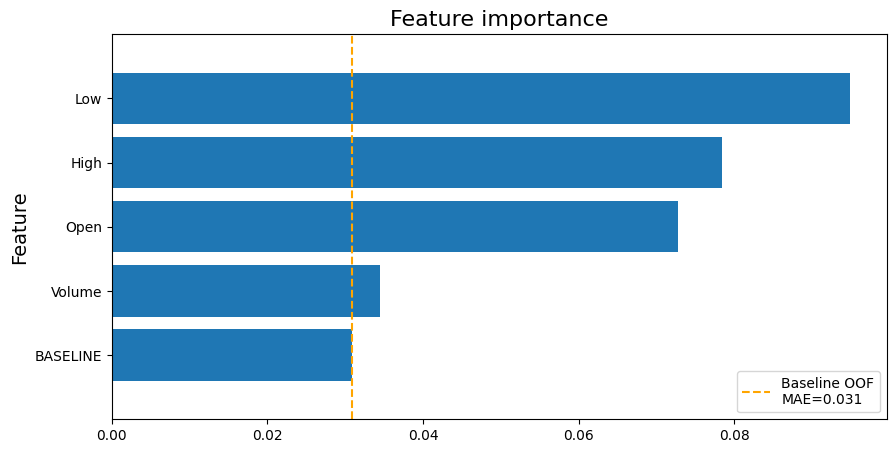

In [18]:
# DISPLAY GRU FEATURE IMPORTANCE
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(10,5))
plt.barh(np.arange(len(COLS)+1),df.mae)
plt.yticks(np.arange(len(COLS)+1),df.feature.values)
plt.title('Feature importance',size=16)
plt.ylim((-1,len(COLS)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
         label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()